In [1]:
#Core Libraries

import pandas as pd
import numpy as np
import warnings
from scipy.stats import chi2_contingency, pearsonr, spearmanr, stats, shapiro
import statsmodels.api as sm

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns


#Machine Learning Libraries

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier
from sklearn.cluster import KMeans

# Set random seed
rs = 42

#Ignore warnings
warnings.filterwarnings('ignore')

# Set color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

In [ ]:
df_train=pd.read_csv("Data/train.csv")
df_test=pd.read_csv("Data/test.csv")

df=pd.concat([df_train, df_test], ignore_index=True)
df_train.head()
print(df.index.duplicated().sum())


0


In [3]:
df.isnull().sum()
print(df["Depression"].value_counts(normalize=True))

Depression
0.0    0.818287
1.0    0.181713
Name: proportion, dtype: float64


In [4]:
print(df_train.shape)
print(df_test.shape)

(140700, 20)
(93800, 19)


In [5]:
df.dtypes

id                                         int64
Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                               float64
dtype: object

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  float64
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             69168 non-null  object 
 7   Academic Pressure                      18767 non-null  float64
 8   Work Pressure                          75022 non-null  float64
 9   CGPA                                   18766 non-null  float64
 10  Study Satisfaction                     18767 non-null  float64
 11  Jo

In [7]:
print(f"There are {df.duplicated().sum()} duplicates in the training data")

There are 0 duplicates in the training data


In [8]:
# Looking for quantity of null values per column

df.isnull().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                61262
Academic Pressure                        187836
Work Pressure                             46696
CGPA                                     187836
Study Satisfaction                       187836
Job Satisfaction                          46684
Sleep Duration                                0
Dietary Habits                                9
Degree                                        4
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                93800
dtype: int64

<Axes: title={'center': 'Visualizing Missing Values'}>

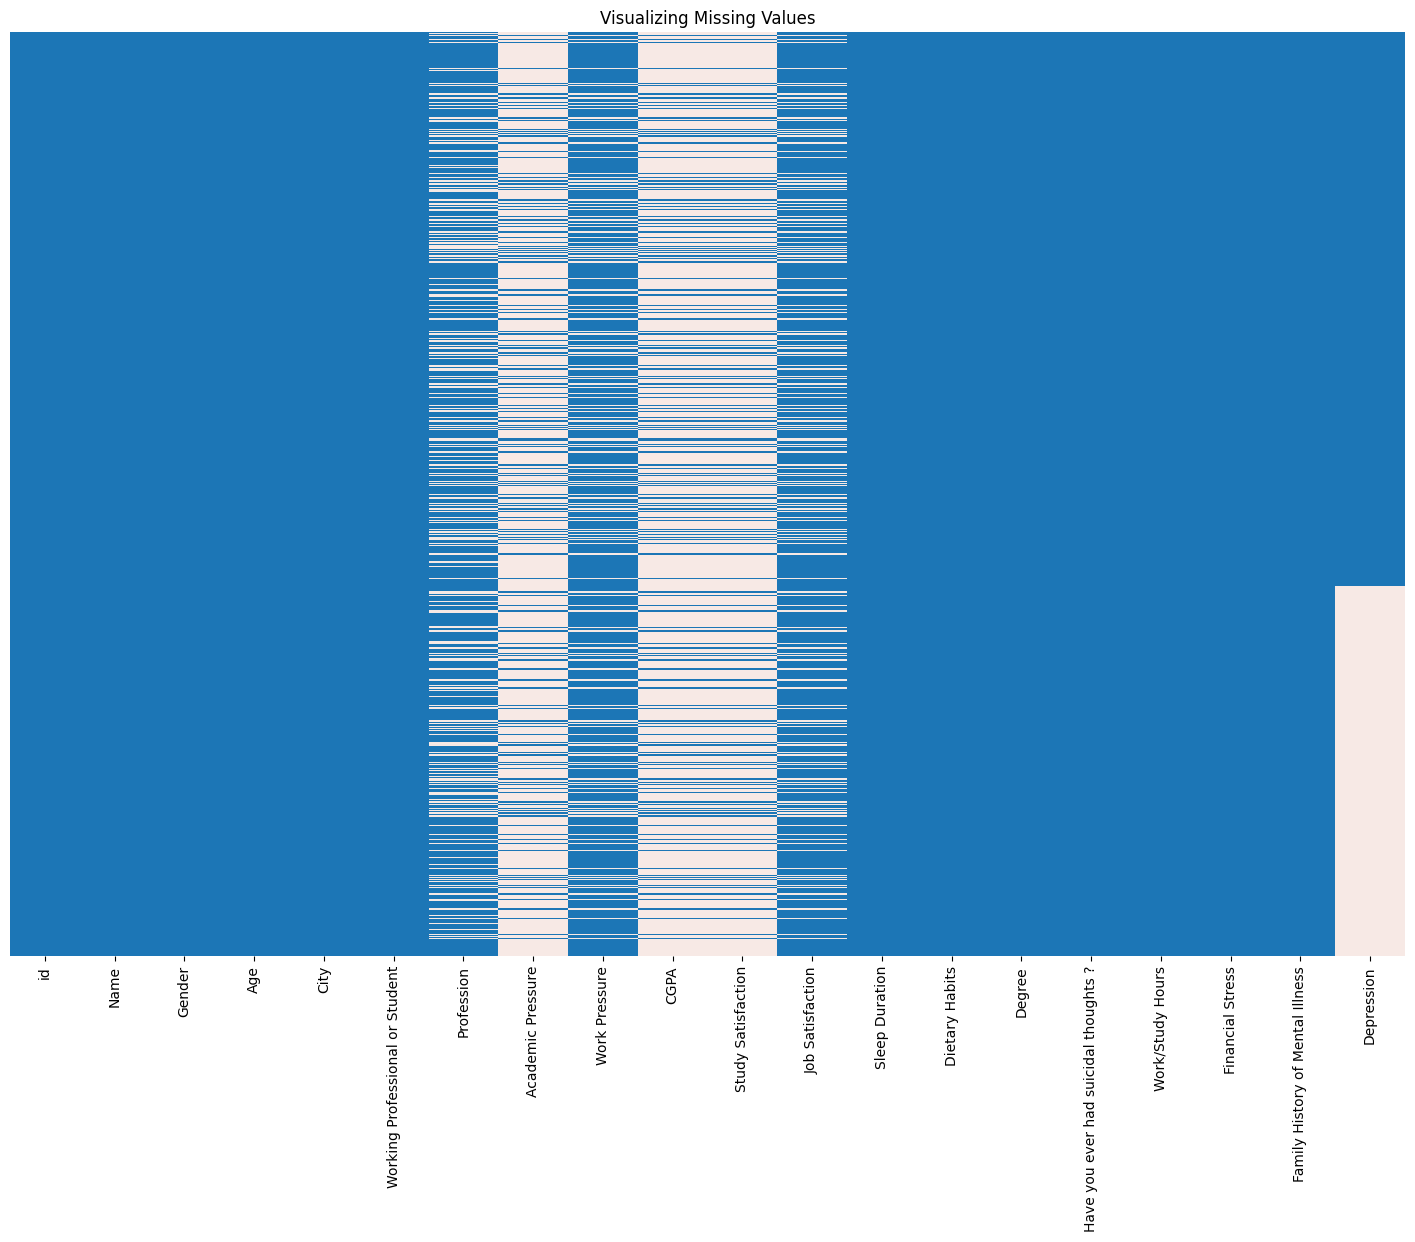

In [9]:
#Plotting a heatmap of null values per column
plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(df.isnull(), cbar=False, cmap=sns.color_palette(colors), yticklabels=False)

In [10]:
df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,234500.0000,234500.000000,46664.000000,187804.000000,46664.000000,46664.000000,187816.000000,234500.000000,234496.000000,140700.000000
mean,117249.5000,40.361847,3.148830,3.004111,7.664821,2.942761,2.969018,6.250542,2.984895,0.181713
std,67694.4634,12.387870,1.382966,1.404900,1.464707,1.365851,1.413948,3.855438,1.414027,0.385609
min,0.0000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,58624.7500,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,117249.5000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,175874.2500,51.000000,4.000000,4.000000,8.930000,4.000000,4.000000,10.000000,4.000000,0.000000
max,234499.0000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [11]:
#Extracting names of target and categorical and numerical features

target_column="Depression"

categorical_columns= df_train.select_dtypes(include=["object"]).columns
numerical_columns=df_train.select_dtypes(exclude=["object"]).columns.drop([target_column, "id"])

print("Target Column: ", target_column)
print("\nCategorical Columns: ", categorical_columns.tolist())
print("\nNumerical Columns: ", numerical_columns.tolist())

print(df.columns)




Target Column:  Depression

Categorical Columns:  ['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

Numerical Columns:  ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']
Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')


In [12]:
#Looking for quantity of unique values by column

for unique in categorical_columns:
    unique_values=df[unique].nunique()
    print(f"{unique} tiene {unique_values} valores únicos.")

Name tiene 554 valores únicos.
Gender tiene 2 valores únicos.
City tiene 124 valores únicos.
Working Professional or Student tiene 2 valores únicos.
Profession tiene 81 valores únicos.
Sleep Duration tiene 46 valores únicos.
Dietary Habits tiene 36 valores únicos.
Degree tiene 156 valores únicos.
Have you ever had suicidal thoughts ? tiene 2 valores únicos.
Family History of Mental Illness tiene 2 valores únicos.


In [13]:
#Transformation

df_t=df.copy()

degree_groups = {
    'Class 12': 'High School',
    'B.Ed': 'Bachelor',
    'B.Arch': 'Bachelor',
    'B.Com': 'Bachelor',
    'B.Pharm': 'Bachelor',
    'BCA': 'Bachelor',
    'BBA': 'Bachelor',
    'BSc': 'Bachelor',
    'M.Ed': 'Master',
    'MCA': 'Master'
}

df_t["Degree"]=df_t["Degree"].map(degree_groups)

In [14]:
#Transformation
df_t=df_t[df_t["Sleep Duration"].isin(["Less than 5 hours", "7-8 hours", "More than 8 hours", "5-6 hours"])]
df_t=df_t[df_t["Dietary Habits"].isin(["Moderate","Unhealthy", "Healthy"])]

In [15]:
#Conteo de clases por columna
for column in categorical_columns:
    print(f"\nTop N values for column {column}:\n{df_t[column].value_counts().head(10)}")


Top N values for column Name:
Name
Rohan          5286
Aarav          3832
Rupak          3608
Aaradhya       3465
Anvi           3430
Raghavendra    3180
Tushar         2764
Vani           2752
Ritvik         2622
Rashi          2610
Name: count, dtype: int64

Top N values for column Gender:
Gender
Male      128625
Female    105685
Name: count, dtype: int64

Top N values for column City:
City
Kalyan           10971
Patna             9807
Vasai-Virar       9652
Kolkata           9407
Ahmedabad         9281
Meerut            9181
Ludhiana          8763
Rajkot            8653
Srinagar          8608
Visakhapatnam     8588
Name: count, dtype: int64

Top N values for column Working Professional or Student:
Working Professional or Student
Working Professional    187686
Student                  46624
Name: count, dtype: int64

Top N values for column Profession:
Profession
Teacher             41265
Content Writer      12989
Architect            7349
Consultant           7140
HR Manager      

In [16]:
#Skewness distribution evaluation

print("The skewness of columns")
print(df_t[numerical_columns].skew())

The skewness of columns
Age                  -0.213658
Academic Pressure    -0.143296
Work Pressure         0.015203
CGPA                 -0.078988
Study Satisfaction    0.014446
Job Satisfaction      0.060589
Work/Study Hours     -0.127505
Financial Stress      0.039591
dtype: float64


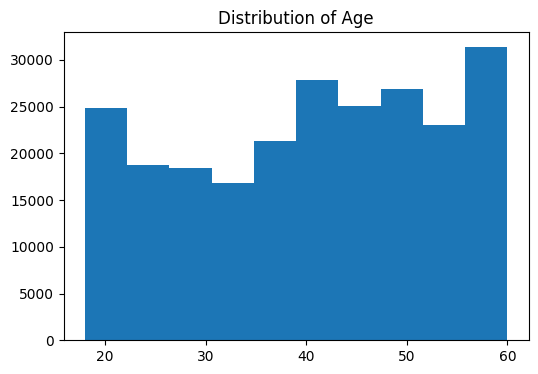

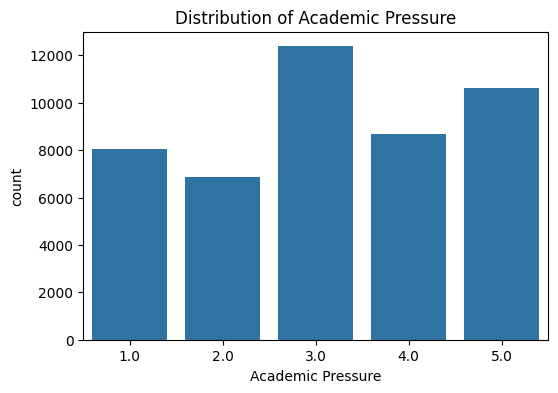

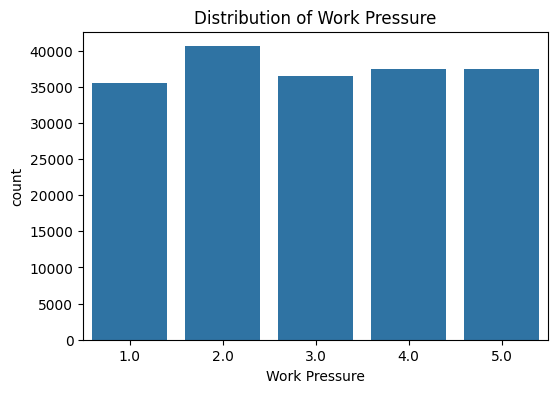

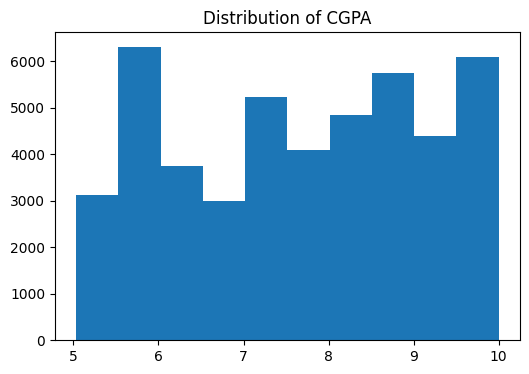

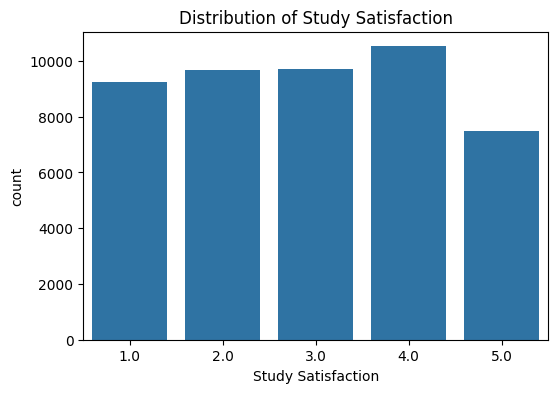

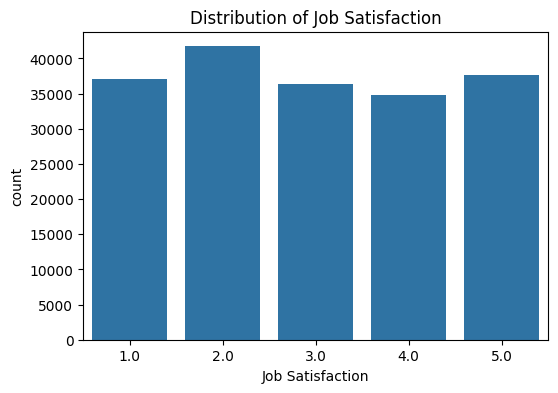

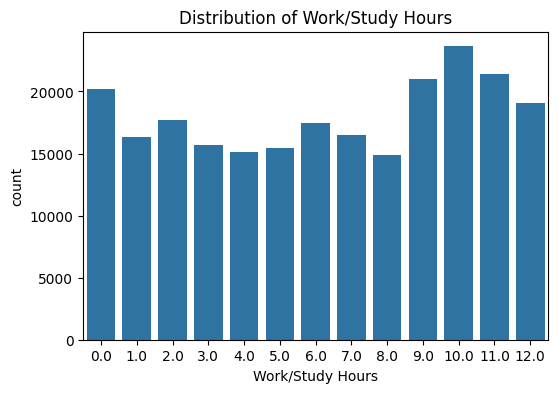

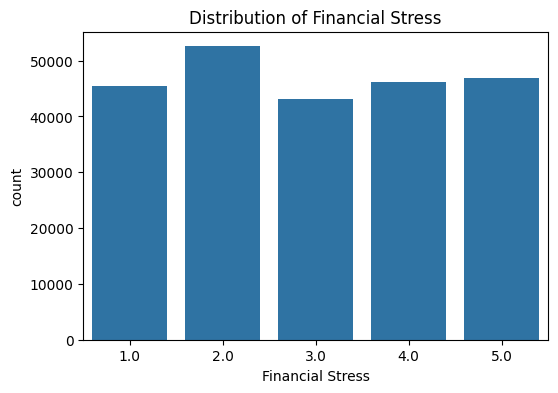

In [17]:
#Plotting histogram and countplots for numerical columns

for columns in numerical_columns:
    if columns in ["CGPA", "Age"]:
        plt.figure(figsize=(6,4))
        plt.title(f"Distribution of {columns}")
        plt.hist(df_t[columns], bins=10)
        plt.show()

    else:
        plt.figure(figsize=(6,4))
        plt.title(f"Distribution of {columns}")
        sns.countplot(x=df_t[columns], color=colors[0])
        plt.show()

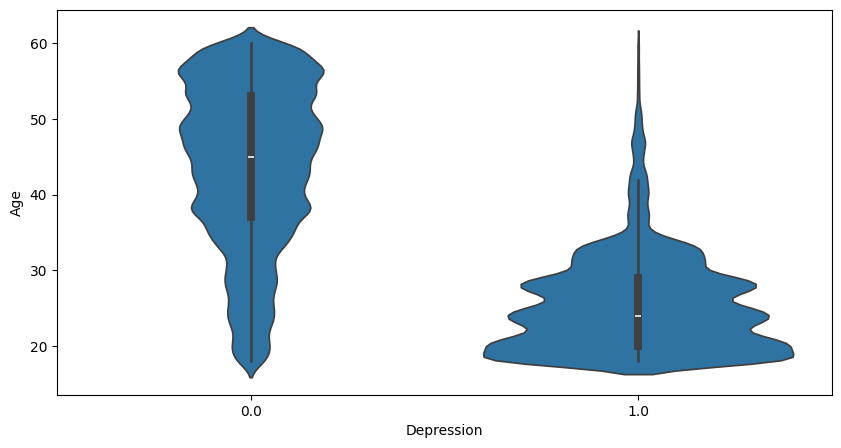

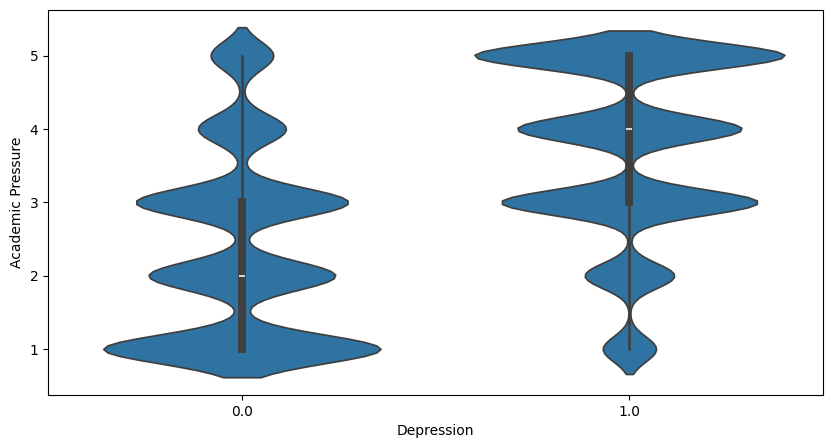

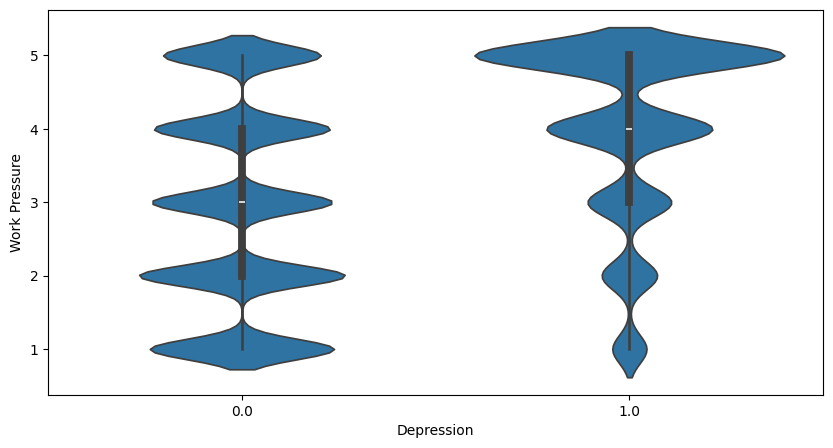

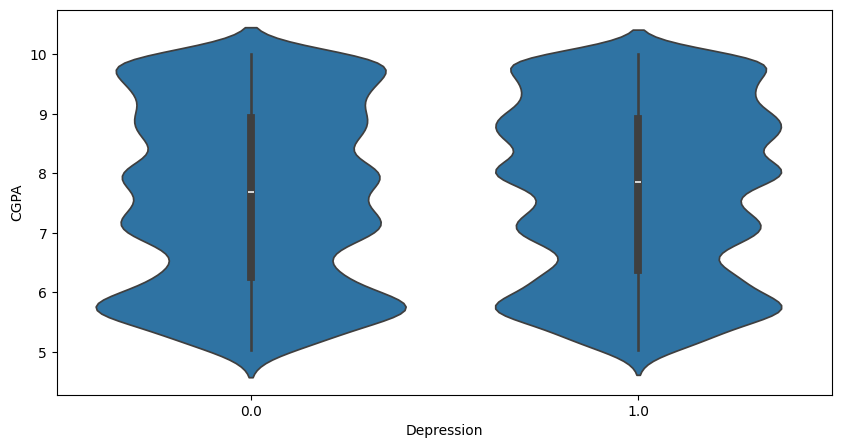

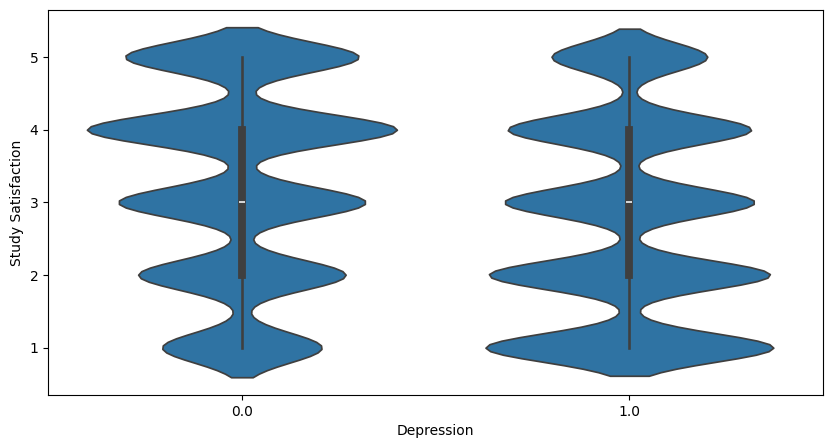

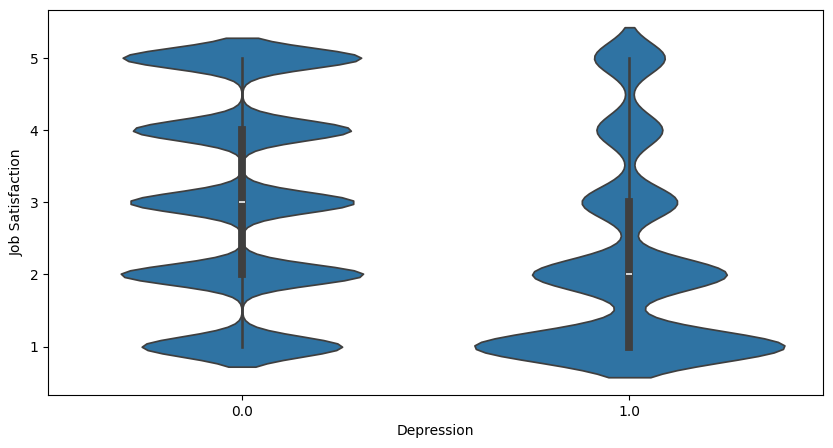

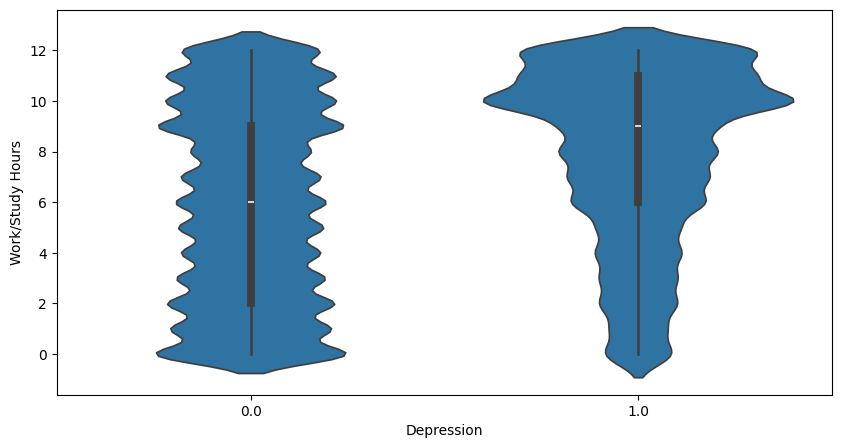

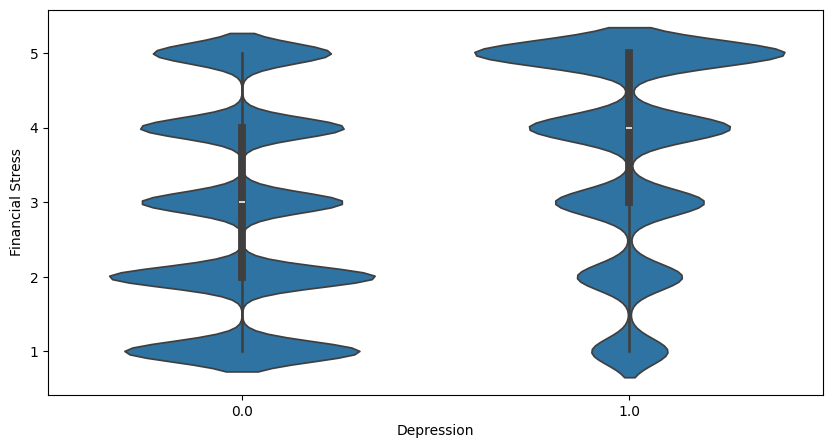

In [18]:
#Plotting Violinplot for numerical columns

for column in numerical_columns:
    plt.figure(figsize=(10,5))
    sns.violinplot(data=df_t, x="Depression", y=column)
    plt.show()


Column: Age, Estadístico:0.9489430072639515, Valor P:7.36674511629303e-111


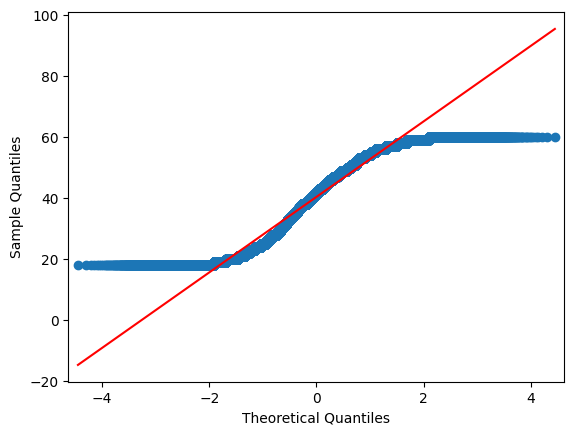


Column: Academic Pressure, Estadístico:nan, Valor P:nan


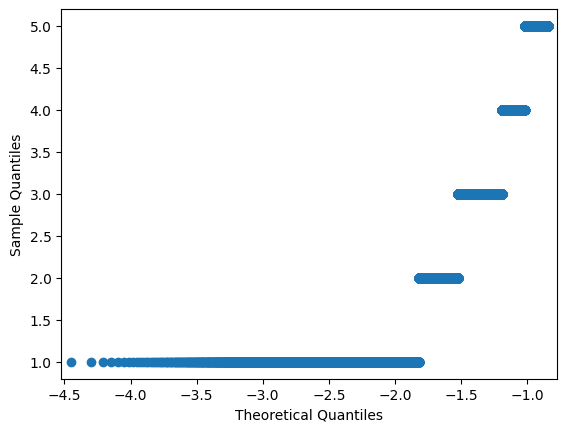


Column: Work Pressure, Estadístico:nan, Valor P:nan


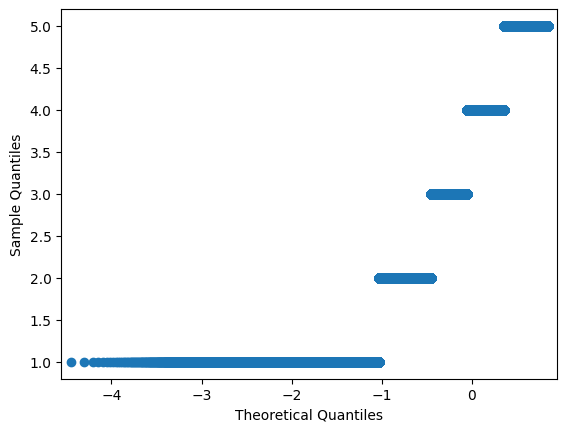


Column: CGPA, Estadístico:nan, Valor P:nan


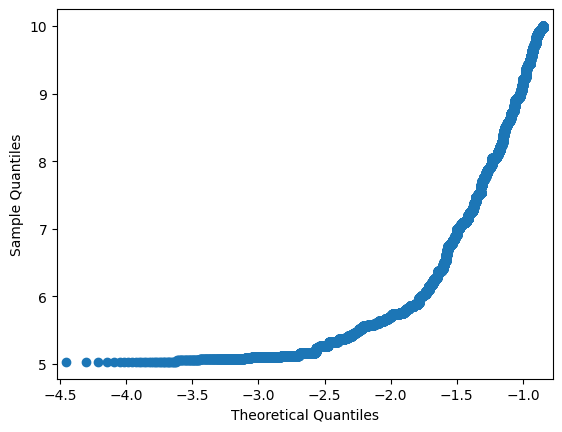


Column: Study Satisfaction, Estadístico:nan, Valor P:nan


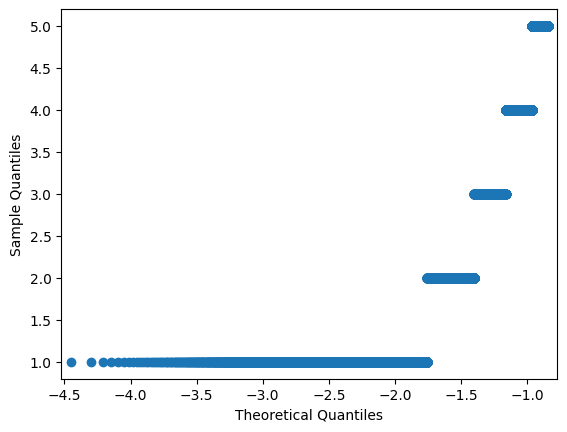


Column: Job Satisfaction, Estadístico:nan, Valor P:nan


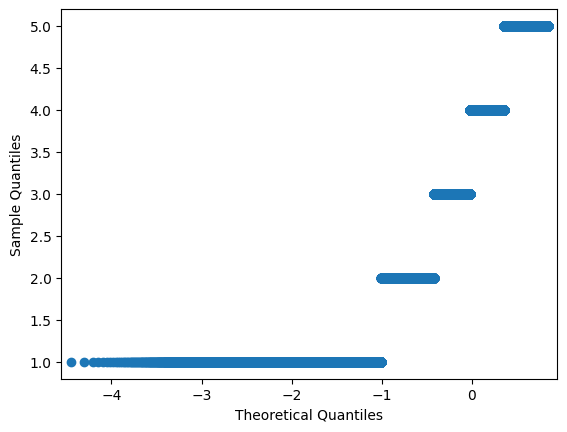


Column: Work/Study Hours, Estadístico:0.9309815935102039, Valor P:2.659209489644952e-119


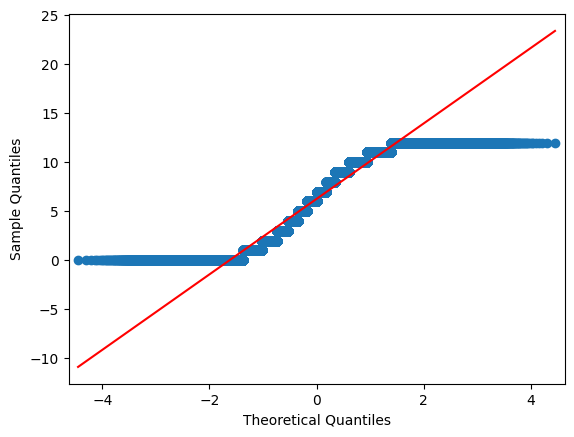


Column: Financial Stress, Estadístico:nan, Valor P:nan


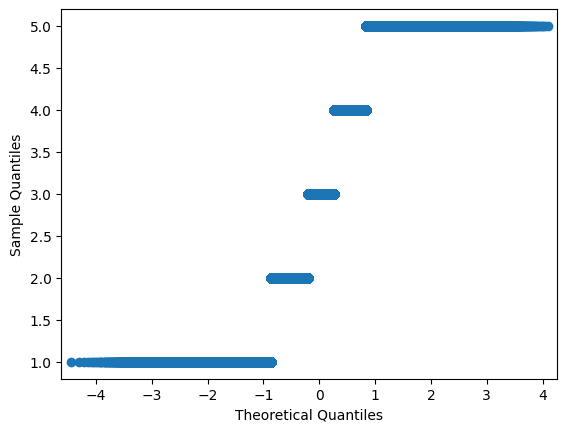

In [19]:
#Evaluating normality with shapiro test. 

for column in numerical_columns:
    stat, p_value=shapiro(df_t[column])
    print(f"\nColumn: {column}, Estadístico:{stat}, Valor P:{p_value}")
    sm.qqplot(df_t[column], line="s")
    plt.show()


In [20]:
#Evaluating relation between categorical variables and target variable with chi**2

for column in categorical_columns:
    tabla_contingencia=pd.crosstab(index=df_t["Depression"], columns=df_t[column])
    print(tabla_contingencia)
    chi2, p, dof, expected=chi2_contingency(tabla_contingencia)
    print(f"\nChi2: {chi2}\nP-Value: {p}\nDOF: {dof}\nExpected: {expected}")

Name        18  A.Ed  Aadhya  Aahana  Aakash  Aam  Aan  Aanchal  Aani  Aanket  \
Depression                                                                      
0.0          0     1     636     470     245    2    1      551     0       1   
1.0          1     0     151     123      67    0    1      133     1       0   

Name        ...  Vrinda  Yamini  Yash  Yashvi  Yogesh  Yurav  Yuvraj  Zahra  \
Depression  ...                                                               
0.0         ...     305     227   316     649     231      1     604      1   
1.0         ...      78      23    73     118     107      0     125      0   

Name        Zara  Zoya  
Depression              
0.0          618   211  
1.0           60    21  

[2 rows x 420 columns]

Chi2: 4719.971259494181
P-Value: 0.0
DOF: 419
Expected: [[8.18299501e-01 8.18299501e-01 6.44001707e+02 4.85251604e+02
  2.55309444e+02 1.63659900e+00 1.63659900e+00 5.59716858e+02
  8.18299501e-01 8.18299501e-01 1.63659900e+00 1.6717

Working Professional or Student  Student  Working Professional
Depression                                                    
0.0                                11552                103496
1.0                                16319                  9227

Chi2: 38121.69697579225
P-Value: 0.0
DOF: 1
Expected: [[22806.82538373 92241.17461627]
 [ 5064.17461627 20481.82538373]]
Profession  Academic  Accountant  Analyst  Architect  B.Com  B.Ed  BBA  BCA  \
Depression                                                                    
0.0                5        1252        1       3935      1     1    1    3   
1.0                0          86        0        432      0     0    0    0   

Profession  BE  Business Analyst  ...  Student  Teacher  Travel Consultant  \
Depression                        ...                                        
0.0          1              2978  ...        7    23508               1774   
1.0          0               179  ...        0     1385                 86 

In [21]:
#Creating new feature
df_t["Age_WorkPressure"]=df_t["Age"]* df_t["Work Pressure"]

df_t=df_t.rename(columns={
    "Working Professional or Student": "Working_Professional_or_Student",
    "Academic Pressure": "Academic_Pressure",
    "Work Pressure": "Work_Pressure",
    "Study Satisfaction": "Study_Satisfaction",
    "Job Satisfaction": "Job_Satisfaction",
    "Sleep Duration": "Sleep_Duration",
    "Dietary Habits": "Dietary_Habits",
    "Have you ever had suicidal thoughts ?":"Suicidal_Thoughts",
    "Work/Study Hours":"Work_Study_Hours",
    "Financial Stress":"Financial_Stress",
    "Family History of Mental Illness":"Family_History_of_Mental_Illness"
})


In [27]:
print(df_t.iloc[30])

id                                         30
Name                                   Prisha
Gender                                 Female
Age                                      28.0
City                                 Varanasi
Working_Professional_or_Student       Student
Profession                                NaN
Academic_Pressure                         3.0
Work_Pressure                             NaN
CGPA                                     5.59
Study_Satisfaction                        2.0
Job_Satisfaction                          NaN
Sleep_Duration                      7-8 hours
Dietary_Habits                       Moderate
Degree                               Bachelor
Suicidal_Thoughts                         Yes
Work_Study_Hours                          4.0
Financial_Stress                          5.0
Family_History_of_Mental_Illness          Yes
Depression                                1.0
Age_WorkPressure                          NaN
Name: 30, dtype: object


In [22]:
#Splitting the dataset in Features and Target variables and in Train and Test datasets


df_t["Depression"]=df_t["Depression"].fillna(2)
df_test=df_t[df_t["Depression"]==2]
df_test=df_test.drop(["Depression", "id", "City", "Name" ], axis=1)

df_train_temp=df_t[df_t["Depression"]!=2]
df_y_train=df_train_temp["Depression"]
df_x_train=df_train_temp.drop(["Depression", "id", "City", "Name"], axis=1)

print(df_x_train.shape)
print(df_y_train.shape)
print(df_test.shape)




(140594, 17)
(140594,)
(93716, 17)


In [23]:
# Defining numerical and categorical columns
numerical_columns2=df_x_train.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_columns2=df_x_train.select_dtypes(include=["object"]).columns.tolist()

print(numerical_columns2)
print(categorical_columns2)

print(df_x_train.info())

['Age', 'Academic_Pressure', 'Work_Pressure', 'CGPA', 'Study_Satisfaction', 'Job_Satisfaction', 'Work_Study_Hours', 'Financial_Stress', 'Age_WorkPressure']
['Gender', 'Working_Professional_or_Student', 'Profession', 'Sleep_Duration', 'Dietary_Habits', 'Degree', 'Suicidal_Thoughts', 'Family_History_of_Mental_Illness']
<class 'pandas.core.frame.DataFrame'>
Index: 140594 entries, 0 to 140699
Data columns (total 17 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Gender                            140594 non-null  object 
 1   Age                               140594 non-null  float64
 2   Working_Professional_or_Student   140594 non-null  object 
 3   Profession                        103997 non-null  object 
 4   Academic_Pressure                 27867 non-null   float64
 5   Work_Pressure                     112706 non-null  float64
 6   CGPA                              27868 non-null   float64

In [24]:
#Conteo de clases por columna
for column in categorical_columns2:
    print(f"\nTop N values for column {column}:\n{df_x_train[column].value_counts().head(10)}")


Top N values for column Gender:
Gender
Male      77406
Female    63188
Name: count, dtype: int64

Top N values for column Working_Professional_or_Student:
Working_Professional_or_Student
Working Professional    112723
Student                  27871
Name: count, dtype: int64

Top N values for column Profession:
Profession
Teacher             24893
Content Writer       7809
Architect            4367
Consultant           4223
HR Manager           4020
Pharmacist           3888
Doctor               3251
Business Analyst     3157
Chemist              2967
Entrepreneur         2966
Name: count, dtype: int64

Top N values for column Sleep_Duration:
Sleep_Duration
Less than 5 hours    38774
7-8 hours            36960
More than 8 hours    32722
5-6 hours            32138
Name: count, dtype: int64

Top N values for column Dietary_Habits:
Dietary_Habits
Moderate     49670
Unhealthy    46201
Healthy      44723
Name: count, dtype: int64

Top N values for column Degree:
Degree
Bachelor       50170


In [25]:
df_x_train.describe()

,Age,Academic_Pressure,Work_Pressure,CGPA,Study_Satisfaction,Job_Satisfaction,Work_Study_Hours,Financial_Stress,Age_WorkPressure
count,140594.000000,27867.000000,112706.000000,27868.000000,27867.000000,112714.000000,140594.000000,140590.000000,112706.000000
mean,40.388736,3.142283,2.999077,7.658731,2.944630,2.974520,6.252706,2.988996,130.417165
std,12.384462,1.380609,1.405832,1.464414,1.360087,1.416122,3.853714,1.413645,69.298173
min,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,18.000000
25%,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,74.000000
50%,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,117.000000
75%,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,180.000000
max,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,300.000000


In [83]:
df_x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140594 entries, 0 to 140699
Data columns (total 17 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Gender                            140594 non-null  object 
 1   Age                               140594 non-null  float64
 2   Working_Professional_or_Student   140594 non-null  object 
 3   Profession                        103997 non-null  object 
 4   Academic_Pressure                 27867 non-null   float64
 5   Work_Pressure                     112706 non-null  float64
 6   CGPA                              27868 non-null   float64
 7   Study_Satisfaction                27867 non-null   float64
 8   Job_Satisfaction                  112714 non-null  float64
 9   Sleep_Duration                    140594 non-null  object 
 10  Dietary_Habits                    140594 non-null  object 
 11  Degree                            75782 non-null   object

In [ ]:
#Making Pipelines for numerical and categorical columns and transformations

num_pipeline=Pipeline([
    ("imputer_num", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline=Pipeline([
    ("imputer_cat", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"))
])


column_transformer=ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numerical_columns2),
        ("cat", cat_pipeline, categorical_columns2),
    
    ], 
)

arr_x_train_encoded=column_transformer.fit_transform(df_x_train)
arr_test_encoded=column_transformer.transform(df_test)


In [77]:
print(arr_x_train_encoded.shape)
print(arr_x_train_encoded.shape)
print(arr_test_encoded.shape)

(140594, 83)
(140594, 83)
(93716, 83)


In [55]:
#Getting feature names and creating a dataframe with the encoded data

#print(X_encoded.shape)
new_column_names=column_transformer.get_feature_names_out()
#df_encoded=pd.DataFrame(X_encoded, columns=new_column_names)
#print(df_encoded.dtypes.unique())
print(new_column_names)

['num__Age' 'num__Academic_Pressure' 'num__Work_Pressure' 'num__CGPA'
 'num__Study_Satisfaction' 'num__Job_Satisfaction' 'num__Work_Study_Hours'
 'num__Financial_Stress' 'num__Age_WorkPressure' 'cat__Gender_Male'
 'cat__Working_Professional_or_Student_Working Professional'
 'cat__Profession_Accountant' 'cat__Profession_Analyst'
 'cat__Profession_Architect' 'cat__Profession_B.Com'
 'cat__Profession_B.Ed' 'cat__Profession_BBA' 'cat__Profession_BCA'
 'cat__Profession_BE' 'cat__Profession_Business Analyst'
 'cat__Profession_Chef' 'cat__Profession_Chemist'
 'cat__Profession_City Manager' 'cat__Profession_Civil Engineer'
 'cat__Profession_Consultant' 'cat__Profession_Content Writer'
 'cat__Profession_Customer Support' 'cat__Profession_Data Scientist'
 'cat__Profession_Dev' 'cat__Profession_Digital Marketer'
 'cat__Profession_Doctor' 'cat__Profession_Educational Consultant'
 'cat__Profession_Electrician' 'cat__Profession_Entrepreneur'
 'cat__Profession_Family Consultant' 'cat__Profession_Fami

In [56]:
#Implementación K-means

kmeans=KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(arr_x_train_encoded)


KMeans(n_clusters=2, n_init=10, random_state=42)

In [57]:
#Kmeans Results and Analysis

labels=kmeans.predict(arr_x_train_encoded)
print(np.unique(labels))
# df_encoded["Cluster"]=kmeans.labels_
# print(df_encoded["Cluster"].value_counts(normalize=True))

[0 1]


In [30]:
#Plotting the clusters (choosing 2 features)

# xs = df_encoded["num__Financial Stress"]
# ys = df_encoded["num__Age_WorkPressure"]
# plt.scatter(xs, ys, c=labels, label='Clusters')
# plt.xlabel("Financial Stress")
# plt.ylabel("Age_workPressure")
# plt.title("Kmeans Clustering")
# plt.legend()
# plt.show()

In [58]:
# Isolation Forest for anomaly detection

isolation_forest=IsolationForest(contamination=0.04, random_state=rs)
outlier_labels=isolation_forest.fit_predict(arr_x_train_encoded)


In [73]:
print(np.unique(outlier_labels))
print(pd.Series(outlier_labels).value_counts(normalize=True))

#Filtering Outliers

non_outliers_mask=outlier_labels != -1
X_train=arr_x_train_encoded[non_outliers_mask]
y_train=df_y_train[non_outliers_mask]
X_test=arr_test_encoded

print(type(X_train))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

[-1  1]
 1    0.959998
-1    0.040002
Name: proportion, dtype: float64
<class 'numpy.ndarray'>
(134970, 83)
(134970,)
(93716, 83)


In [60]:
#Plotting the anomalies

df_anomalies=pd.DataFrame(arr_x_train_encoded, columns=new_column_names)
df_anomalies["Outlier"]=outlier_labels

plt.figure(figsize=(10,5))
sns.scatterplot(data=df_anomalies, x="num__Age_WorkPressure", y="num__Financial Stress", hue="Outlier")
plt.title("Outliers Detection")
plt.show()

ValueError: Could not interpret value `num__Financial Stress` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

In [61]:
#Defining hyperparameters for the models

xgb_params={
    "n_estimators": 100,
    "max_depth": 3,
    "learning_rate": 0.1,
}

catboost_params={
    "iterations": 100,
    "depth": 3,
    "learning_rate": 0.1
}

hgb_params={
    "max_iter": 100,
    "max_depth": 3
}

In [108]:
#Defining the models

xgb_model=XGBClassifier(**xgb_params, use_label_encoder=False, random_state=rs)
catboost_model=CatBoostClassifier(**catboost_params, verbose=0, random_state=rs)
hgb_model=HistGradientBoostingClassifier(**hgb_params, random_state=rs)

In [109]:
#Stacking Ensemble

stacking_ensemble=StackingClassifier(
    estimators=[
        ("catboost", catboost_model),
        ("xgb", xgb_model),
        ("hgb", hgb_model)

    ],
    final_estimator=LogisticRegression(), 
    passthrough=False

)

In [110]:
#Define scoring metric

scoring=make_scorer(accuracy_score)
cv_scores=cross_val_score(stacking_ensemble, X_train, y_train, cv=5, scoring=scoring)

print(f"Cross Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean()}")
print(f"Standard Deviation: {cv_scores.std()}")

Cross Validation Scores: [0.93872712 0.93939394 0.93950508 0.93902349 0.94032007]
Mean Accuracy: 0.9393939393939394
Standard Deviation: 0.0005388781668805803


In [62]:
#Modeling with XGBoost

scoring2=make_scorer(accuracy_score)
xgb2 = XGBClassifier(use_label_encoder=False, random_state=rs)

"""params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]
}"""

"""params = {
    "n_estimators": [100, 80],
    "learning_rate": [0.01]
}"""

#grid_xgb = GridSearchCV(estimator=xgb2, scoring="accuracy", param_grid=params, cv=3, n_jobs=-1)

cv_scores2=cross_val_score(xgb2, X_train, y_train, cv=5, scoring=scoring2)

#grid_xgb.fit(X_train, y_train)

In [36]:
print(f"Cross Validation Scores: {cv_scores2}")
print(f"Mean Accuracy: {cv_scores2.mean()}")
print(f"Standard Deviation: {cv_scores2.std()}")

Cross Validation Scores: [0.93791213 0.94057939 0.93909758 0.94028303 0.94139438]
Mean Accuracy: 0.9398533007334962
Standard Deviation: 0.0012186936471779858


In [ ]:
#Fit the XGB model and predict

xgb2.fit(X_train, y_train)
y_pred=xgb2.predict(X_test)



In [46]:
#Create a Dataframe

df_submission=df_test.copy()

df_submission["Depression"]=y_pred

df_submission.head()

df_submission[df_submission["Depression"]==1]
#print(df_submission.shape)
#print(y_pred.shape)


,Gender,Age,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Age_WorkPressure,Depression
140703,Female,23.0,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,Bachelor,Yes,10.0,4.0,No,NaN,1
140709,Male,21.0,Working Professional,NaN,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Healthy,High School,Yes,10.0,4.0,No,105.0,1
140713,Male,18.0,Working Professional,NaN,NaN,5.0,NaN,NaN,2.0,5-6 hours,Moderate,High School,Yes,0.0,2.0,No,90.0,1
140719,Male,28.0,Student,NaN,5.0,NaN,6.03,3.0,NaN,7-8 hours,Moderate,NaN,No,11.0,3.0,Yes,NaN,1
140720,Female,26.0,Student,NaN,3.0,NaN,8.63,5.0,NaN,More than 8 hours,Moderate,Bachelor,Yes,10.0,4.0,Yes,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234480,Female,19.0,Student,NaN,5.0,NaN,7.25,3.0,NaN,Less than 5 hours,Moderate,High School,Yes,11.0,1.0,Yes,NaN,1
234485,Male,33.0,Student,NaN,5.0,NaN,5.74,2.0,NaN,7-8 hours,Moderate,Bachelor,Yes,12.0,5.0,Yes,NaN,1
234492,Male,23.0,Working Professional,Consultant,NaN,2.0,NaN,NaN,3.0,Less than 5 hours,Moderate,Bachelor,Yes,12.0,4.0,No,46.0,1
234496,Male,29.0,Working Professional,Pilot,NaN,5.0,NaN,NaN,1.0,7-8 hours,Moderate,NaN,Yes,11.0,3.0,Yes,145.0,1
